# Building Animal Classification Model

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import os

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
!nvidia-smi

Sat Jul 19 10:45:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              3W /   50W |    1109MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
root_path = Path("animal_faces")
train_dir = root_path / "train"
val_dir = root_path / "val"

train_dir, val_dir

(PosixPath('animal_faces/train'), PosixPath('animal_faces/val'))

Class: wild


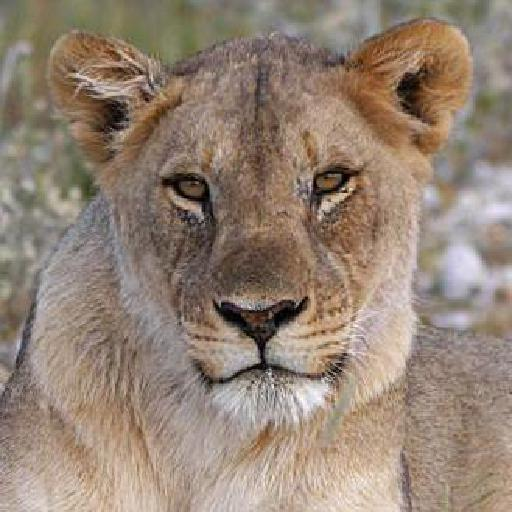

In [31]:
# get any random image
import random

random.seed(42)
image_path_list = list(root_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

# open the random image
img = Image.open(random_image_path)
print(f"Class: {random_image_path.parent.stem}")
img

## Create a Transform

In [32]:
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

## Create Custom Datasets using `ImageFolder`

In [33]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform)

val_data = datasets.ImageFolder(root = val_dir,
                                transform = data_transform)

train_data, val_data

(Dataset ImageFolder
     Number of datapoints: 14630
     Root location: animal_faces/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1500
     Root location: animal_faces/val
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

## Create Train & Val Dataloaders

In [34]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_data,
                              shuffle = True,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_data,
                            shuffle = False,
                            batch_size = BATCH_SIZE,
                            num_workers = NUM_WORKERS)

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79120d354ad0>,
 <torch.utils.data.dataloader.DataLoader at 0x79120a74d700>)

In [35]:
len(train_dataloader), len(val_dataloader)

(229, 24)

## Create The Model

In [36]:
class AnimalFaceRecognitionModel(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),

            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),

            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),

            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),

            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p = 0.5),
            nn.Linear(in_features = hidden_units * 14 * 14, out_features = output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [37]:
# create an instance of the class
torch.manual_seed(42)

model_0 = AnimalFaceRecognitionModel(input_shape = 3,
                                     hidden_units = 32,
                                     output_shape = len(train_data.classes)).to(device)

model_0

AnimalFaceRecognitionModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(star

## Define Loss Function & Optimizer

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.01)

In [39]:
# do a forward pass to find the no. of in_features in the classifier layer
for x, y in val_dataloader:
    x, y = x.to(device), y.to(device)
    y_random_pred = model_0(x)
    print(y_random_pred)
    break

tensor([[-2.9075e-01,  4.6011e-01, -1.0450e+00],
        [ 1.9279e-01,  1.0835e+00,  1.8357e+00],
        [-1.1952e-01,  1.6503e-01, -1.0240e+00],
        [ 2.9758e-01,  4.8534e-01,  1.2985e+00],
        [ 6.4621e-02,  7.1142e-01, -5.4949e-01],
        [ 4.9342e-01,  1.0149e+00,  4.8016e-02],
        [-5.2464e-01,  1.5081e+00, -7.3645e-01],
        [-1.0386e+00,  1.0112e-01, -3.7903e-01],
        [-1.4036e-01,  1.7113e+00, -1.1612e+00],
        [-5.8899e-01,  3.1057e-01,  8.6028e-01],
        [ 5.4562e-01,  1.8848e-01, -2.5335e-02],
        [ 2.9914e-02,  7.5693e-01,  3.3774e-01],
        [-8.8923e-01, -6.8196e-01,  1.4294e-01],
        [-4.9220e-02,  1.5351e+00, -8.8930e-02],
        [-3.6705e-01,  8.5138e-01,  2.0960e+00],
        [-6.9072e-01,  1.0979e+00,  5.6043e-02],
        [-3.6236e-01,  1.7590e+00, -7.9970e-01],
        [ 2.8132e-01,  1.9516e-01, -4.7326e-01],
        [-2.3970e-01,  2.4479e-01,  1.3170e-01],
        [-2.6970e-03,  3.0463e-01, -9.5808e-01],
        [-2.8575e-02

## Create Training & Testing Loop

In [40]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

epochs = 5

start_time = timer()

for epoch in tqdm(range(epochs)):
    total_train_loss = 0
    total_train_acc = 0
    total_val_loss = 0
    total_val_acc = 0

    for (x, y) in train_dataloader:
        x, y = x.to(device), y.to(device)

        model_0.train()

        y_pred = model_0(x)
        loss = loss_fn(y_pred, y)
        total_train_loss = total_train_loss + loss.item()

        optimizer.zero_grad()   
        loss.backward()
        optimizer.step()

        total_train_acc = total_train_acc + (torch.argmax(torch.softmax(y_pred, dim=1), dim=1) == y).sum().item() / len(y_pred)

    with torch.inference_mode():
        for (x_test, y_test) in val_dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)

            y_test_pred = model_0(x_test)

            test_loss = loss_fn(y_test_pred, y_test)
            total_val_loss = total_val_loss + test_loss.item()

            total_val_acc = total_val_acc + (torch.argmax(torch.softmax(y_test_pred, dim=1), dim=1) == y_test).sum().item() / len(y_test_pred)

    total_train_loss = total_train_loss / len(train_dataloader)
    total_val_loss = total_val_loss / len(val_dataloader)
    total_train_acc = total_train_acc * 100 / len(train_dataloader)
    total_val_acc = total_val_acc * 100 / len(val_dataloader)

    print(f"Epoch: {epoch} | Train Loss: {total_train_loss} | Train Acc: {total_train_acc} | Test Loss: {total_val_loss} | Test Acc: {total_val_acc}")


end_time = timer()

print(f"Total time taken on device: {device}: {end_time - start_time:.3f}")

 20%|██        | 1/5 [00:16<01:07, 16.93s/it]

Epoch: 0 | Train Loss: 1.4350807237312784 | Train Acc: 65.83148988738222 | Test Loss: 0.7874074603120486 | Test Acc: 67.55022321428572


 40%|████      | 2/5 [00:32<00:47, 15.93s/it]

Epoch: 1 | Train Loss: 0.4409994864307637 | Train Acc: 82.80747242013331 | Test Loss: 0.6721484201649824 | Test Acc: 76.89732142857143


 60%|██████    | 3/5 [00:46<00:30, 15.39s/it]

Epoch: 2 | Train Loss: 0.2637203108340372 | Train Acc: 90.20124683980694 | Test Loss: 0.5302346957226595 | Test Acc: 80.47805059523809


 80%|████████  | 4/5 [01:02<00:15, 15.64s/it]

Epoch: 3 | Train Loss: 0.19702920020765352 | Train Acc: 92.77644507009883 | Test Loss: 0.4811080638319254 | Test Acc: 84.00297619047619


100%|██████████| 5/5 [01:18<00:00, 15.75s/it]

Epoch: 4 | Train Loss: 0.16242915544837844 | Train Acc: 94.10228970351643 | Test Loss: 0.469018647292008 | Test Acc: 84.65401785714285
Total time taken on device: cuda: 78.761


## Train The Model With Data Augmentation

In [41]:
# create transform

augment_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

In [42]:
# create augmented data
train_augmented_data = datasets.ImageFolder(root = train_dir,
                                            transform = augment_transform)

# create the dataloader
train_augment_dataloader = DataLoader(dataset = train_augmented_data,
                                      batch_size = BATCH_SIZE,
                                      num_workers = NUM_WORKERS,
                                      shuffle = True)

In [43]:
# make another instance of the class

torch.manual_seed(42)

model_1 = AnimalFaceRecognitionModel(input_shape = 3,
                                     hidden_units = 32,
                                     output_shape = len(train_augmented_data.classes)).to(device)

model_1

AnimalFaceRecognitionModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(star

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr =  0.01)

In [ ]:
epochs = 10

start_time = timer()

for epoch in tqdm(range(epochs)):
    total_train_loss = 0
    total_train_acc = 0
    total_val_loss = 0
    total_val_acc = 0

    for (x, y) in train_augment_dataloader:
        x, y = x.to(device), y.to(device)

        model_1.train() 

        y_pred = model_1(x)
        loss = loss_fn(y_pred, y)
        total_train_loss = total_train_loss + loss.item()

        optimizer.zero_grad()   
        loss.backward()
        optimizer.step()

        total_train_acc = total_train_acc + (torch.argmax(torch.softmax(y_pred, dim=1), dim=1) == y).sum().item() / len(y_pred)

    model_1.eval()

    with torch.inference_mode():
        for (x_test, y_test) in val_dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)

            y_test_pred = model_1(x_test)

            test_loss = loss_fn(y_test_pred, y_test)
            total_val_loss = total_val_loss + test_loss.item()

            total_val_acc = total_val_acc + (torch.argmax(torch.softmax(y_test_pred, dim=1), dim=1) == y_test).sum().item() / len(y_test_pred)

    total_train_loss = total_train_loss / len(train_augment_dataloader)
    total_val_loss = total_val_loss / len(val_dataloader)
    total_train_acc = total_train_acc * 100 / len(train_augment_dataloader)
    total_val_acc = total_val_acc * 100 / len(val_dataloader)

    print(f"Epoch: {epoch} | Train Loss: {total_train_loss} | Train Acc: {total_train_acc} | Test Loss: {total_val_loss} | Test Acc: {total_val_acc}")


end_time = timer()

print(f"Total time taken on device {device} With Data Augmentation: {end_time - start_time:.3f} seconds")

 10%|█         | 1/10 [00:15<02:15, 15.09s/it]

Epoch: 0 | Train Loss: 0.20925604753749338 | Train Acc: 92.02554010572283 | Test Loss: 0.06908898150625949 | Test Acc: 97.72135416666667


 20%|██        | 2/10 [00:31<02:06, 15.78s/it]

Epoch: 1 | Train Loss: 0.19992941134816694 | Train Acc: 92.51644736842107 | Test Loss: 0.06213471969628396 | Test Acc: 98.2421875


 30%|███       | 3/10 [00:46<01:49, 15.66s/it]

Epoch: 2 | Train Loss: 0.19293187278034124 | Train Acc: 92.87843311882327 | Test Loss: 0.06771325669978978 | Test Acc: 97.78645833333333


 40%|████      | 4/10 [01:02<01:33, 15.53s/it]

Epoch: 3 | Train Loss: 0.1994464631196453 | Train Acc: 92.46688979544933 | Test Loss: 0.0894936010420982 | Test Acc: 97.265625


 50%|█████     | 5/10 [01:17<01:16, 15.30s/it]

Epoch: 4 | Train Loss: 0.2108369417260828 | Train Acc: 92.10310848080901 | Test Loss: 0.06637357292735639 | Test Acc: 97.8515625


 60%|██████    | 6/10 [01:33<01:02, 15.66s/it]

Epoch: 5 | Train Loss: 0.20286878946696826 | Train Acc: 92.485204550678 | Test Loss: 0.09095301076134395 | Test Acc: 97.00520833333333


 70%|███████   | 7/10 [01:49<00:47, 15.79s/it]

Epoch: 6 | Train Loss: 0.2092084827544127 | Train Acc: 92.04600953803724 | Test Loss: 0.061634304525796324 | Test Acc: 97.98177083333333


 80%|████████  | 8/10 [02:05<00:31, 15.83s/it]

Epoch: 7 | Train Loss: 0.19237026250128142 | Train Acc: 92.73047862560333 | Test Loss: 0.10598874543453955 | Test Acc: 96.15885416666667


 90%|█████████ | 9/10 [02:20<00:15, 15.70s/it]

Epoch: 8 | Train Loss: 0.20450658686296388 | Train Acc: 92.23957136290508 | Test Loss: 0.06675643531101134 | Test Acc: 98.11197916666667


100%|██████████| 10/10 [02:37<00:00, 15.73s/it]

Epoch: 9 | Train Loss: 0.20382151975577054 | Train Acc: 92.4123046426109 | Test Loss: 0.09326327423332259 | Test Acc: 97.13541666666667
Total time taken on device cuda With Data Augmentation: 157.279 seconds
